Data Parsed:
        Timestamp             Sender  \
0  23/07/22 07.44        Mba Lintang   
1  09/08/22 22.57             Monica   
2  16/08/22 22.38  +62 821-3190-2620   
3  16/08/22 22.39  +62 812-5375-7347   
4  16/08/22 22.41  +62 821-3190-2620   

                                             Message  
0  ‎IMG-20220722-WA0067.jpg (file terlampir) *[TE...  
1  Waalaikumsalam, untuk kelompok itu akan dibagi...  
2  <Media tidak disertakan> Nih masi ad slot 7 ka...  
3           Boleh nih, cuma aku baru berangkat besok  
4  Saya tanya biaya sewa include listrik Partaun ...  

Top terms per cluster (k=3):
Cluster 0: dihapus, pesan, https, mas, whatsapp
Cluster 1: disertakan, media, 2022, yg, 2024
Cluster 2: aku, mas, ra, ga, belum

Top terms per cluster (k=4):
Cluster 0: aku, https, whatsapp, yg, ya
Cluster 1: disertakan, media, 2022, yg, 2024
Cluster 2: dihapus, pesan, we, 15, 16
Cluster 3: mas, aku, ga, ra, iki

Top terms per cluster (k=5):
Cluster 0: mas, yg, ya, ums, info
Cluster 

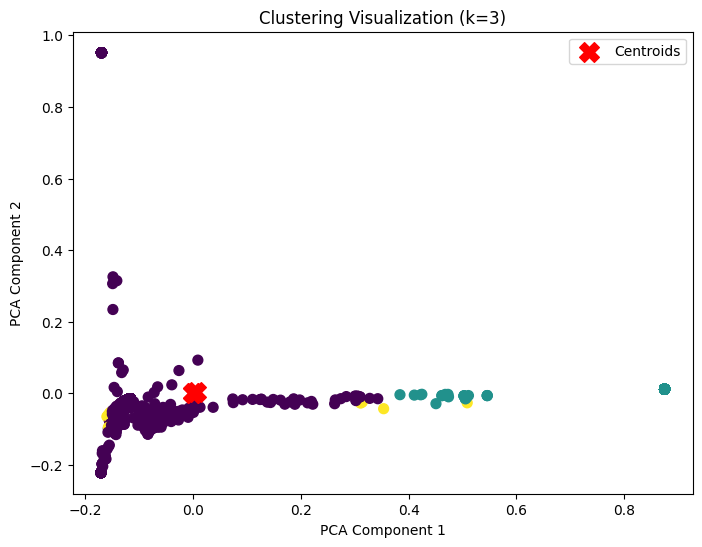

In [2]:
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === 1. Membaca dan Membersihkan Data ===
def parse_whatsapp_data(file_path):
    """
    Membaca file WhatsApp chat dan memisahkan menjadi kolom: Timestamp, Sender, dan Message.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    data = []
    pattern = r"(\d{2}/\d{2}/\d{2,4} \d{2}.\d{2}) - (.*?): (.+)"
    for line in lines:
        match = re.match(pattern, line)
        if match:
            timestamp, sender, message = match.groups()
            data.append([timestamp, sender, message])
        else:
            # Jika tidak sesuai format, tambahkan ke pesan sebelumnya
            if data:
                data[-1][2] += " " + line.strip()

    return pd.DataFrame(data, columns=["Timestamp", "Sender", "Message"])

# Path file WhatsApp chat
file_path = "data_group_whatsapp.txt"
df = parse_whatsapp_data(file_path)

# Menampilkan beberapa data untuk verifikasi
print("Data Parsed:")
print(df.head())

# === 2. Daftar Stopwords Bahasa Indonesia ===
stopwords_id = [
    "yang", "dan", "di", "ke", "dari", "ini", "itu", "untuk", "dengan",
    "saya", "kamu", "tidak", "ada", "bisa", "kita", "akan", "pada", "sudah",
    "juga", "karena", "mereka", "saja", "hanya", "atau", "lagi"
    # Anda dapat menambahkan lebih banyak stopwords di sini
]

# === 3. TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(stop_words=stopwords_id, max_features=500)
X = vectorizer.fit_transform(df['Message'])

# === 4. Clustering dengan K-Means ===
k_values = [3, 4, 5]  # Jumlah cluster yang akan diuji
results = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    labels = kmeans.labels_
    results[k] = {
        "model": kmeans,
        "labels": labels,
    }

    # Menampilkan Top Terms per Cluster
    print(f"\nTop terms per cluster (k={k}):")
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names_out()

    for i in range(k):
        top_terms = [terms[ind] for ind in order_centroids[i, :5]]
        print(f"Cluster {i}: {', '.join(top_terms)}")

# === 5. Visualisasi Cluster (k=3) ===
k = 3  # Pilih jumlah cluster untuk visualisasi
kmeans = results[k]["model"]
reduced_data = PCA(n_components=2).fit_transform(X.toarray())

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title(f"Clustering Visualization (k={k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()
